In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, Model, Input
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score


In [2]:
all_draft_data = pd.read_csv('../data/2025/all_draft_data.csv')
all_draft_data.head()

,pick_no,round,scoring_type,qb_need,rb_need,wr_need,te_need,k_need,dst_need,flex_need,...,dst_available,flex_available,qb_vor,rb_vor,wr_vor,te_vor,k_vor,flex_vor,position_drafted,draft_id
0,1,1,0.0,1,2,2,1,1,1,2,...,32,151,69.0,164.0,125.0,68.0,17.0,164.0,WR,1224007842931937280
1,2,1,0.0,1,2,2,1,1,1,2,...,32,150,69.0,164.0,116.0,68.0,17.0,164.0,WR,1224007842931937280
2,3,1,0.0,1,2,2,1,1,1,2,...,32,149,69.0,164.0,116.0,68.0,17.0,164.0,RB,1224007842931937280
3,4,1,0.0,1,2,2,1,1,1,2,...,32,148,69.0,154.0,116.0,68.0,17.0,154.0,RB,1224007842931937280
4,5,1,0.0,1,2,2,1,1,1,2,...,32,147,69.0,154.0,116.0,68.0,17.0,154.0,WR,1224007842931937280


In [3]:
draft_data = all_draft_data[~all_draft_data['round'].isin([14, 15])].copy()
draft_data.drop(columns=['k_need','k_available','k_vor','other_k_need','dst_available','dst_need','other_dst_need'            ], inplace=True)

#draft_data.drop(columns=['qb_need', 'other_qb_need', 'qb_vor', 'qb_available'], inplace=True)
#draft_data.drop(columns=['te_need', 'other_te_need', 'te_vor', 'te_available'], inplace=True)

draft_data = draft_data[~draft_data['position_drafted'].isin(['QB', 'TE'])].copy()

numeric_cols = [
    'qb_need', 'other_qb_need', 'qb_vor', 'qb_available',
    'rb_need', 'other_rb_need', 'rb_vor', 'rb_available',
    'wr_need', 'other_wr_need', 'wr_vor', 'wr_available',
    'te_need', 'other_te_need', 'te_vor', 'te_available',
    'round', 'pick_no'
]
scaler = StandardScaler()
draft_data[numeric_cols] = draft_data[numeric_cols].astype(float)
draft_data['pick_no'] /= draft_data['pick_no'].max()
draft_data.loc[:, numeric_cols] = scaler.fit_transform(draft_data[numeric_cols])

le = LabelEncoder()
draft_data['position_drafted_encoded'] = le.fit_transform(draft_data['position_drafted'])

In [4]:
train_val, test = train_test_split(draft_data, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)
X_train = train.drop(columns=['draft_id', 'position_drafted','position_drafted_encoded'])
y_train = train['position_drafted_encoded']
X_val = val.drop(columns=['draft_id', 'position_drafted','position_drafted_encoded'])
y_val = val['position_drafted_encoded']
X_test = test.drop(columns=['draft_id', 'position_drafted','position_drafted_encoded'])
y_test = test['position_drafted_encoded']


In [5]:
y_train = le.transform(train['position_drafted'])
y_val = le.transform(val['position_drafted'])
y_test = le.transform(test['position_drafted'])
position_mapping = dict(enumerate(le.classes_))

print(position_mapping)

{0: 'RB', 1: 'WR'}


In [6]:
print(f"X Train Shape: {X_train.shape}")
print(f"X Test Shape: {X_test.shape}")
print(f"X Val Shape: {X_val.shape}")
print(f"y Train Shape: {y_train.shape}")
print(f"y Test Shape: {y_test.shape}")
print(f"y Val Shape: {y_val.shape}")

X Train Shape: (1719, 23)
X Test Shape: (574, 23)
X Val Shape: (573, 23)
y Train Shape: (1719,)
y Test Shape: (574,)
y Val Shape: (573,)


In [7]:
model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1]),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(position_mapping), activation='softmax')
])

In [8]:

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer= "adam",
    metrics=["accuracy"]
)


In [9]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    batch_size=15
)

Epoch 1/30


2025-05-19 14:26:54.938154: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


115/115 [==============================] - 1s 4ms/step - loss: 0.8889 - accuracy: 0.5404 - val_loss: 0.8244 - val_accuracy: 0.4747
Epoch 2/30
115/115 [==============================] - 0s 2ms/step - loss: 0.7263 - accuracy: 0.5311 - val_loss: 0.9072 - val_accuracy: 0.5253
Epoch 3/30
115/115 [==============================] - 0s 2ms/step - loss: 0.7033 - accuracy: 0.5358 - val_loss: 0.6946 - val_accuracy: 0.5061
Epoch 4/30
115/115 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5486 - val_loss: 0.7206 - val_accuracy: 0.4747
Epoch 5/30
115/115 [==============================] - 0s 2ms/step - loss: 0.6860 - accuracy: 0.5689 - val_loss: 0.6954 - val_accuracy: 0.5253
Epoch 6/30
115/115 [==============================] - 0s 2ms/step - loss: 0.6830 - accuracy: 0.5486 - val_loss: 0.7077 - val_accuracy: 0.5445
Epoch 7/30
115/115 [==============================] - 0s 2ms/step - loss: 0.6833 - accuracy: 0.5596 - val_loss: 0.7092 - val_accuracy: 0.4956
Epoch 8/30
115/11

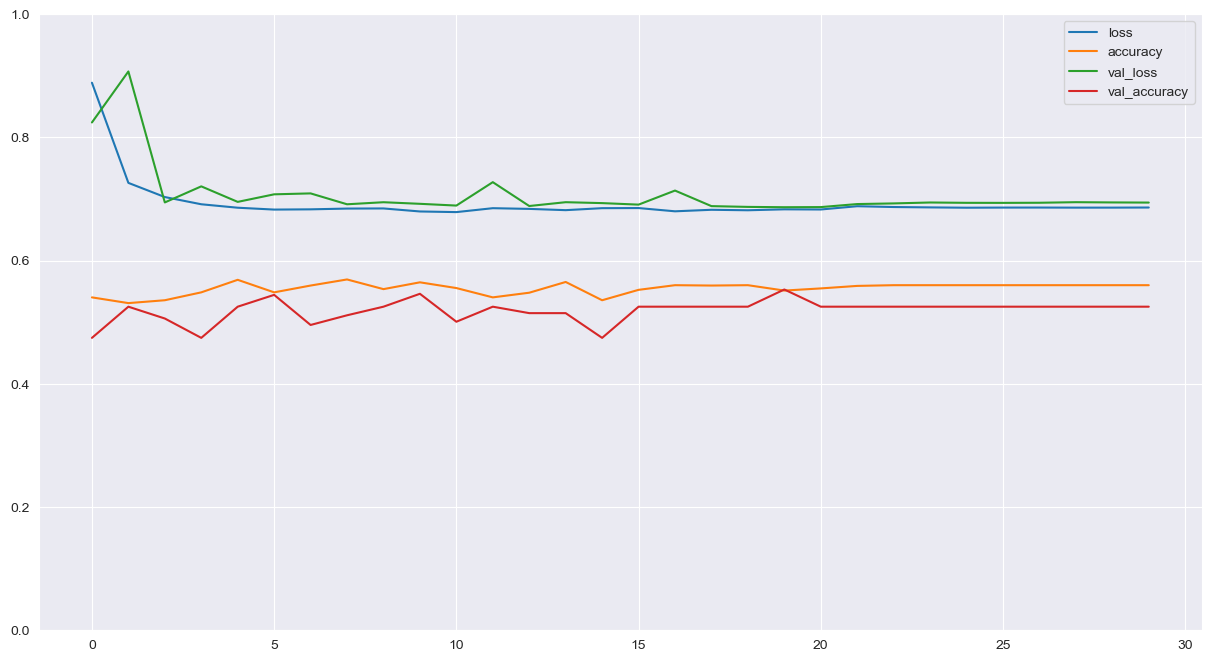

In [10]:
pd.DataFrame(history.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [17]:
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_labels)
print(f"Cohen's Kappa:{kappa}")

18/18 [==============================] - 0s 594us/step
Cohen's Kappa:0.0


In [14]:
print(pd.Series(draft_data['position_drafted_encoded']).value_counts())
for idx, label in enumerate(le.classes_):
    print(f"{label}: {idx}")

position_drafted_encoded
1    1581
0    1285
Name: count, dtype: int64
RB: 0
WR: 1


In [15]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
print("Validation accuracy:", xgb_model.score(X_val, y_val))

Validation accuracy: 0.6579406631762653


In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Validation accuracy:", rf.score(X_val, y_val))

Validation accuracy: 0.631762652705061
